In [1]:
import os
import re
import pandas as pd
from datetime import datetime
import urllib.request

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.types import *
import pyspark.sql.functions as psf

import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline

os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.10:0.4.1 pyspark-shell'

In [2]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.session.timeZone', 'UTC')
sc = spark.sparkContext
sqlContext = SQLContext(sc)

# Load Data

In [3]:
dir_data_opensub = 'parquets/'

In [4]:
df_sp0 = spark.read.parquet(dir_data_opensub+'films.parquet')
df_ratings = spark.read.parquet('ratings.parquet')
df_basics = spark.read.parquet('basics.parquet')

In [5]:
df_sp0.count()

4286

In [6]:
s_sp = df_sp0.take(2)
s_ratings = df_ratings.take(2)
s_basics = df_basics.take(2)

In [7]:
s_basics

[Row(tconst='tt0000001', titleType='short', primaryTitle='Carmencita', originalTitle='Carmencita', isAdult='0', startYear='1894', endYear='\\N', runtimeMinutes=1.0, genres=['Documentary', 'Short']),
 Row(tconst='tt0000002', titleType='short', primaryTitle='Le clown et ses chiens', originalTitle='Le clown et ses chiens', isAdult='0', startYear='1892', endYear='\\N', runtimeMinutes=5.0, genres=['Animation', 'Short'])]

In [8]:
df_join = df_sp0.join(other=df_basics,
                     on='tconst',
                     how='inner')

### Drop columns and convert to pandas 

In [9]:
cols = df_join.columns 

In [10]:
print(cols)

['tconst', 'num_subtitles', 'year', 'blocks', 'subtitle_mins', 'subtitles', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes', 'genres']


In [11]:
# remove columns from dropping list
cols.remove('tconst')
cols.remove('year')
cols.remove('genres')

In [12]:
# 
df_sp1 = df_join
for col in cols: 
    df_sp1 = df_sp1.drop(col)

In [13]:
df_sp1.show()

+---------+----+--------------------+
|   tconst|year|              genres|
+---------+----+--------------------+
|tt0032553|1940|[Comedy, Drama, War]|
|tt0032599|1940|[Comedy, Drama, R...|
|tt0036323|1943|[Action, Drama, War]|
|tt0039305|1947|[Crime, Drama, Fi...|
|tt0063688|1968|[Crime, Drama, Ro...|
|tt0066193|1970|            [Comedy]|
|tt0100142|1990|[Comedy, Drama, R...|
|tt0102216|1991|   [Comedy, Romance]|
|tt0107840|1993|    [Drama, Romance]|
|tt0117718|1996|             [Drama]|
|tt0204946|2000|[Comedy, Romance,...|
|tt0383028|2008|     [Comedy, Drama]|
|tt0449010|2006|[Action, Adventur...|
|tt0456165|2005|[Comedy, Drama, R...|
|tt0463854|2007|[Drama, Horror, S...|
|tt0464049|2006|[Comedy, Drama, R...|
|tt1031969|2008|     [Comedy, Music]|
|tt1188990|2008|  [Horror, Thriller]|
|tt1280558|2008|[Crime, Drama, My...|
|tt1529572|2010|[Crime, Drama, Th...|
+---------+----+--------------------+
only showing top 20 rows



explode "genres" column 

In [14]:
df_sp2 = df_sp1.select("tconst", "year", psf.explode_outer("genres")).withColumnRenamed('col', 'genre')

In [15]:
# convert to pandas 
df_pd1 = df_sp2.toPandas()

In [16]:
df_pd1.head()

,tconst,year,genre
0,tt0032553,1940,Comedy
1,tt0032553,1940,Drama
2,tt0032553,1940,War
3,tt0032599,1940,Comedy
4,tt0032599,1940,Drama


# Graphs 

In [17]:
counts_genres = df_pd1.groupby(['genre']).size()
counts_genres

genre
Action          879
Adventure       652
Animation       182
Biography       276
Comedy         1525
Crime           835
Documentary     113
Drama          2446
Family          210
Fantasy         310
Film-Noir        51
History         167
Horror          523
Music           133
Musical          71
Mystery         364
News              3
Romance         769
Sci-Fi          270
Sport            93
Thriller        657
War             145
Western          60
dtype: int64

In [18]:
counts_genres = counts_genres.sort_values(ascending=True).reset_index().rename(columns={0:'counts'})

In [19]:
counts_genres.head()

,genre,counts
0,News,3
1,Film-Noir,51
2,Western,60
3,Musical,71
4,Sport,93


In [20]:
# to change aspect of the plots to look like latex

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix';
matplotlib.rcParams['font.family'] = 'STIXGeneral';
# matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$');

NameError: name 'np' is not defined

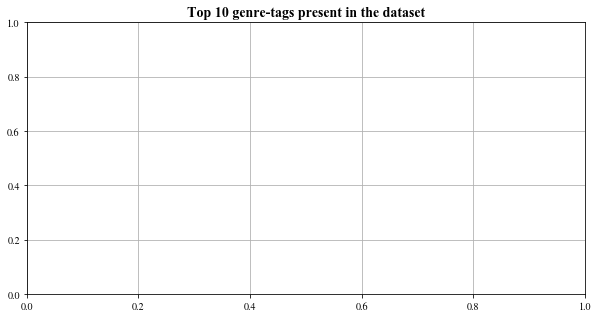

In [21]:
# choose number of genres to plot 
n = 10
top5_genres = counts_genres[-n:]
hfont = {'fontname':'Times New Roman'}
plt.figure(figsize=(10,5))
plt.title('Top 10 genre-tags present in the dataset', {'fontsize':14}, **hfont)
plt.grid()
positions = np.arange(len(top5_genres))
plt.barh(positions,
         width=top5_genres['counts'],
         align='center',
         color='black')
plt.yticks(positions,
           top5_genres['genre'],
           fontsize=14);
plt.xticks(fontsize=14)
ax = plt.gca()
ax.set_facecolor((224/255, 224/255, 224/255))


## Scatter plots by genre 

#### Start fresh 

In [ ]:
dir_data_opensub = 'parquets/'

In [ ]:
df_sp0 = spark.read.parquet(dir_data_opensub+'films.parquet')
df_ratings = spark.read.parquet('ratings.parquet')
df_basics = spark.read.parquet('basics.parquet')

In [ ]:
def word_statistics(df_films):
    df_words = df_films.select('*', psf.explode('subtitles').alias('words'))
    df_words = df_words.select('*', psf.explode('words').alias('word'))
    df_word_counts = df_words.groupby("tconst", "num_subtitles", "blocks", "subtitle_mins")\
                             .agg(psf.count("word").alias("Number of words"), 
                                  psf.countDistinct("word").alias("Number of distinct words"))\
                             .withColumn("Mean length of sentences",
                                         psf.col("Number of words") / psf.col("num_subtitles"))\
                             .withColumn("Spread of sentences",
                                         psf.col("num_subtitles") / psf.col("blocks"))
    return df_word_counts

#### Create df for word statistics : 

In [ ]:
df_word_stats = word_statistics(df_sp0)

In [ ]:
df_word_stats.show()

#### Get tconst for filtering 

In [ ]:
df_tconst = df_sp0.select('tconst')

#### Filter imdb basics data 

In [ ]:
df_basics.count()

In [ ]:
df_basics_F = df_tconst.join(other=df_basics, 
                             on='tconst', 
                             how='inner') 

In [ ]:
df_basics_F.count()

#### Get genre for each imdb-id

In [ ]:
df_basics.columns 

#### Explode genres into genre

In [ ]:
# take only the genre column and tconst and explode genres into genre
df_genre = df_basics_F.select('tconst',psf.explode_outer('genres'))\
                      .withColumnRenamed('col', 'genre')

In [ ]:
df_genre.show()

#### Counting the number of entries in `df_genres`: 

In [ ]:
df_genre.count()

#### Join with df_w_stats

In [ ]:
# explode genres column
df_w_join = df_word_stats.join(other=df_genre, 
                               on='tconst',
                               how='inner')


In [ ]:
df_w_join.count()

#### Join with ratings 

In [ ]:
df_genre_scat = df_w_join.join(other=df_ratings,
                               on='tconst', 
                               how='inner')

In [ ]:
df_genre_scat.count()

### Plots for top 10 genres

#### Convert da shit to pandas homie 


In [ ]:
df_pd = df_genre_scat.toPandas() 

In [ ]:
df_pd.head()

In [ ]:
print(df_pd.columns)

#### Top 10 genres : 

In [ ]:
def scatter_plotter(df,fg=True,genre='Drama'): 
    
    if fg: 
        df_g = df[df['genre'] == genre]
    else: 
        df_g = df 
    
    ax = df_g.plot.scatter("num_subtitles","averageRating")
    ax = df_g.plot.scatter("blocks", "averageRating")
    ax = df_g.plot.scatter("subtitle_mins", "averageRating")
    
    ax = df_g.plot.scatter("Number of words", "averageRating")
    ax = df_g.plot.scatter("Number of distinct words", "averageRating")
    
    ax = df_g.plot.scatter("Mean length of sentences", "averageRating")
    ax = df_g.plot.scatter("Spread of sentences", "averageRating")

#### Plots for Drama 

In [ ]:
scatter_plotter(df_pd,genre='Drama')

#### Plots for Comedy

In [ ]:
scatter_plotter(df_pd,genre='Comedy')

#### Plots for Action

In [ ]:
scatter_plotter(df_pd,genre='Action')

#### Plots for Crime

In [ ]:
scatter_plotter(df_pd,genre='Crime')

#### Plots for Romance 

In [ ]:
scatter_plotter(df_pd,genre='Romance')

#### Plots for Thriller

In [ ]:
scatter_plotter(df_pd,genre='Thriller')

#### Plots for Adventure

In [ ]:
scatter_plotter(df_pd,genre='Adventure')

#### Plots for Horror

In [ ]:
scatter_plotter(df_pd,genre='Horror')

#### Plots for Mystery

In [ ]:
scatter_plotter(df_pd,genre='Mystery')

#### Plots for Fantasy

In [ ]:
scatter_plotter(df_pd,genre='Fantasy')